In [ ]:
IMG_ROWS = 480
IMG_COLS = 320

In [ ]:
import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob
import zipfile
#import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from subprocess import check_output
print(check_output(["ls", "../content/drive/MyDrive/Segmentation/FinalDatasetThesis/train"]).decode("utf8"))

images
masks



In [ ]:
train_img_paths = sorted(glob('../content/drive/MyDrive/Segmentation/FinalDatasetThesis/train/images/*.jpg'))
train_mask_paths = sorted(glob('../content/drive/MyDrive/Segmentation/FinalDatasetThesis/train/masks/*.png'))

In [ ]:
test_img_paths = sorted(glob('../content/drive/MyDrive/Segmentation/FinalDatasetThesis/val/images/*.jpg'))
test_mask_paths = sorted(glob('../content/drive/MyDrive/Segmentation/FinalDatasetThesis/val/masks/*.png'))

In [ ]:
train_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_img_paths])

train_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_mask_paths])

train_masks = train_masks.astype(np.float32)
train_masks[train_masks<=127] = 0.
train_masks[train_masks>127] = 1.
train_masks = np.reshape(train_masks, (*train_masks.shape, 1))

<ipython-input-8-2131d7017561>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
<ipython-input-8-2131d7017561>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))


In [ ]:
test_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in test_img_paths])

test_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in test_mask_paths])

test_masks = test_masks.astype(np.float32)
test_masks[test_masks<=127] = 0.
test_masks[test_masks>127] = 1.
test_masks = np.reshape(test_masks, (*test_masks.shape, 1))

<ipython-input-9-849ddd32e5ee>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
<ipython-input-9-849ddd32e5ee>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))


# Train Image

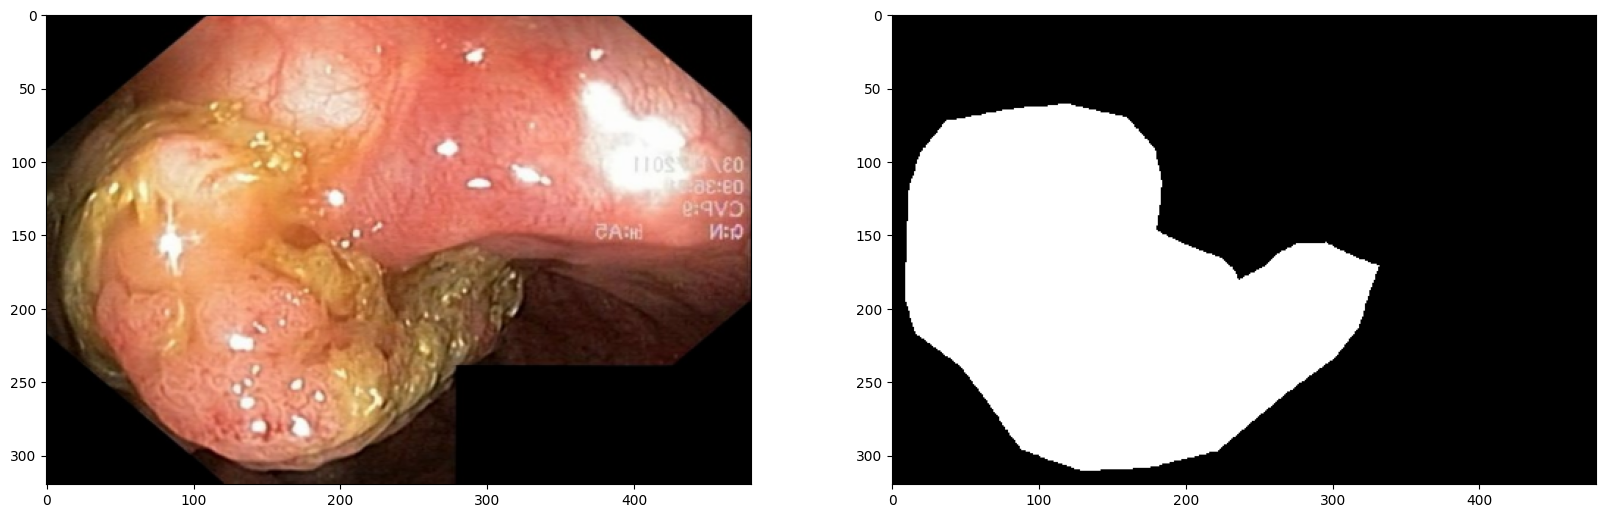

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[0])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[0]), cmap='gray')

# Test image

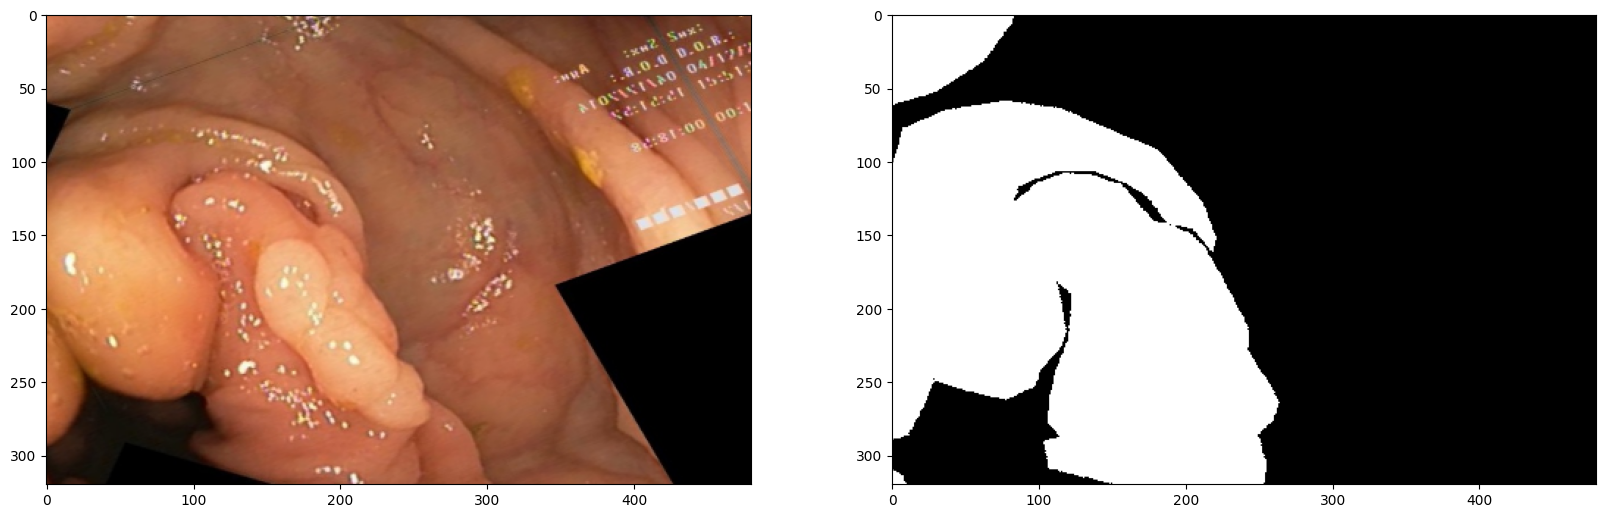

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(test_imgs[0])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(test_masks[0]), cmap='gray')

# Model

In [ ]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from tensorflow.keras.optimizers import Adam
BACKBONE = 'resnext50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)

# define optomizer
#optim = keras.optimizers.Adam(0.001)
optimizer = Adam(learning_rate=0.001)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
loss = tf.keras.losses.BinaryCrossentropy()
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
model.summary()

## Set the loss function

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy

def IoULoss(y_true, y_pred, smooth=1e-6):

    #flatten label and prediction tensors
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)

    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

## Запускаем процесс обучения

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Assuming you have defined the 'model' architecture and loaded data

# Define your loss function
loss = tf.keras.losses.BinaryCrossentropy()  # Replace with your desired loss function

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Now you can proceed with fitting your model


from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics
model.compile(Adam(lr=1e-4),
              tensorflow.keras.metrics.MeanIoU(num_classes=2),
              metrics=[tensorflow.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
history=model.fit(
    train_imgs[50:],         # Training images (from index 50 to the end)
    train_masks[50:],        # Corresponding masks (from index 50 to the end)
    batch_size=32,           # Batch size for training
    epochs=100,               # Number of training epochs
    validation_data=(
        train_imgs[:50],     # Validation images (first 50)
        train_masks[:50]     # Corresponding masks (first 50)
    )
)


Epoch 1/100


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have defined the 'model', 'train_imgs', and 'train_masks'

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_imgs[50:],
    train_masks[50:],
    batch_size=32,
    epochs=100,
    validation_data=(
        train_imgs[:50],
        train_masks[:50]
    ),
    callbacks=[early_stopping]  # Add the early stopping callback
)


Epoch 1/100
24/24 [==============================] - 107s 2s/step - loss: 0.5066 - accuracy: 0.7631 - val_loss: 0.5626 - val_accuracy: 0.7693
Epoch 2/100
24/24 [==============================] - 31s 1s/step - loss: 0.4544 - accuracy: 0.7659 - val_loss: 0.5609 - val_accuracy: 0.7717
Epoch 3/100
24/24 [==============================] - 30s 1s/step - loss: 0.4372 - accuracy: 0.7723 - val_loss: 0.5348 - val_accuracy: 0.5915
Epoch 4/100
24/24 [==============================] - 31s 1s/step - loss: 0.4296 - accuracy: 0.7766 - val_loss: 0.5232 - val_accuracy: 0.6119
Epoch 5/100
24/24 [==============================] - 30s 1s/step - loss: 0.4265 - accuracy: 0.7795 - val_loss: 0.4482 - val_accuracy: 0.7603
Epoch 6/100
24/24 [==============================] - 30s 1s/step - loss: 0.4178 - accuracy: 0.7891 - val_loss: 0.4471 - val_accuracy: 0.7556
Epoch 7/100
24/24 [==============================] - 31s 1s/step - loss: 0.4011 - accuracy: 0.8040 - val_loss: 0.4015 - val_accuracy: 0.8069
Epoch 8/100


## Предсказание модели

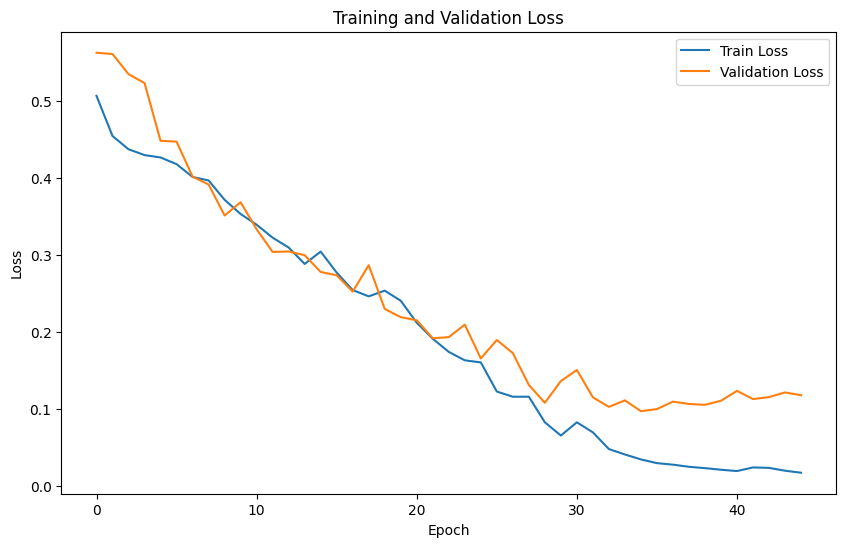

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

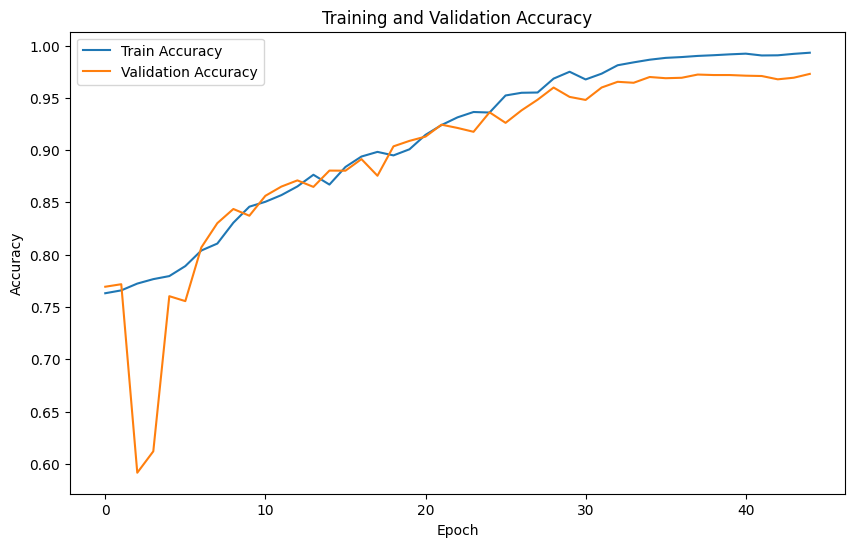

In [ ]:
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 49ms/step


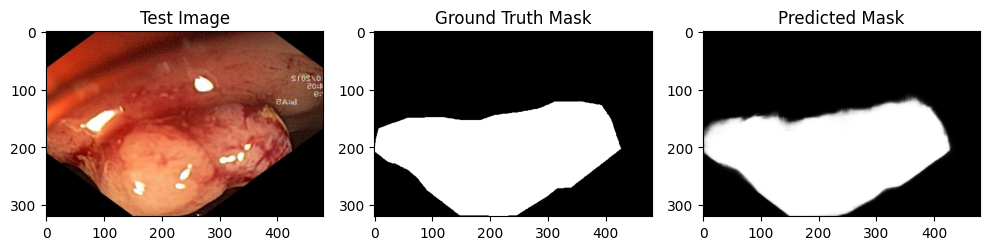

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


test_index = 101

# Get the test image and mask
test_image = test_imgs[test_index]
ground_truth_mask = test_masks[test_index]

# Predict the mask using the trained model
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot the test image, ground truth mask, and predicted mask
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(132)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(133)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 30ms/step


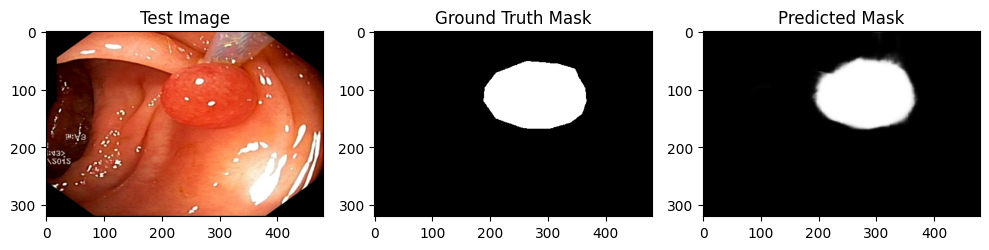

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


test_index = 102

# Get the test image and mask
test_image = test_imgs[test_index]
ground_truth_mask = test_masks[test_index]

# Predict the mask using the trained model
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot the test image, ground truth mask, and predicted mask
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(132)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(133)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 35ms/step


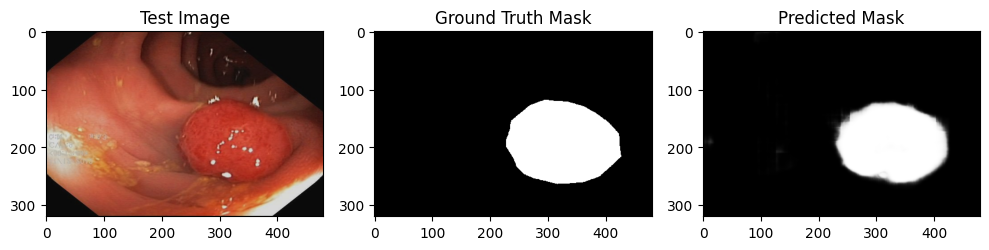

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


test_index = 110

# Get the test image and mask
test_image = test_imgs[test_index]
ground_truth_mask = test_masks[test_index]

# Predict the mask using the trained model
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot the test image, ground truth mask, and predicted mask
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(test_image)
plt.title('Test Image')

plt.subplot(132)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(133)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.models import save_model

# Assuming you have defined and trained the 'model'
# model = ...

# Save the trained model to an HDF5 file in your Google Drive
save_model(model, '/content/drive/MyDrive/segmentation_modelV2.h5')

print("Model saved as 'segmentation_model.h5'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved as 'segmentation_model.h5'


In [ ]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_masks, batch_size=32)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 7s 1s/step - loss: 0.1357 - accuracy: 0.9622
Test Loss: 0.135708749294281
Test Accuracy: 0.9621990919113159


In [ ]:
train_loss, train_accuracy = model.evaluate(train_imgs, train_masks, batch_size=32)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

25/25 [==============================] - 9s 367ms/step - loss: 0.0326 - accuracy: 0.9875
Train Loss: 0.032632194459438324
Train Accuracy: 0.9874637722969055


In [ ]:
test_paths = sorted(glob('../content/drive/MyDrive/Segmentation/FinalDatasetThesis/val/*.png'))

def test_img_generator(test_paths):
    while True:
        for path in test_paths:
            yield np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))])

pred = model.predict_generator(test_img_generator(test_paths[:10]), len(test_paths[:10]))

## Визуализируем результат

fig = plt.figure(0, figsize=(20, 10))
k = 5
fig.add_subplot(2, 2, 1)
plt.imshow(imageio.imread(test_paths[k]))
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(cv2.resize(pred[k], (TEST_IMG_ROWS, TEST_IMG_COLS))), cmap='gray')
fig.add_subplot(2, 2, 3)
plt.imshow(imageio.imread(test_paths[k+1]))
fig.add_subplot(2, 2, 4)
plt.imshow(np.squeeze(cv2.resize(pred[k+1], (TEST_IMG_ROWS, TEST_IMG_COLS))), cmap='gray')

## Подготавливаем данные для отправки

In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

imageio.imread(path).shape[0]

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,EncodedPixels\n')
    for path in test_paths:
        img = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))])
        pred_mask = model.predict(img)[0]
        bin_mask = 255. * cv2.resize(pred_mask, (imageio.imread(path).shape[0], imageio.imread(path).shape[1]))
        bin_mask[bin_mask<=127] = 0
        bin_mask[bin_mask>127] = 1
        rle = rle_encode(bin_mask.astype(np.uint8))
        rle = ' '.join(str(x) for x in rle)
        dst.write('%s,%s\n' % (path.split('/')[-1].split('.')[0], rle))

In [ ]:
import csv

with open('submit.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('submission.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerows(lines)